In [1]:
import torch
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
import os
import imgaug
from tqdm.auto import tqdm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# "../train1/video_10/segmentation/000000000.png"
DATASET_DIR = ".."
VIDEO_DIRS = glob(os.path.join(DATASET_DIR, "train*", "video*"))
VIDEO_DIRS[:2]

['..\\train1\\video_10', '..\\train1\\video_11_1']

In [3]:
class MICCAIDataset(torch.utils.data.Dataset):
    def __init__(self, config, aug=False):
        data_dir = config['data_dir']
        self.mask_paths = sorted(glob(os.path.join(data_dir, 'segmentation/*.png')))
        self.img_paths = [p.replace('segmentation', 'rgb') for p in self.mask_paths]
        self.img_h = config['img_h']
        self.img_w = config['img_w']
        self.aug = aug
#         self.seq = iaa.Sequential([
#             iaa.Fliplr(0.5),  # 50% horizontal flip
#             iaa.Affine(
#                 rotate=(-15, 15),
#                 shear=(-10, 10),
#                 scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
#             ),
#         ])

    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])[:, :, ::-1]
        mask = cv2.imread(self.mask_paths[idx])[:, :, 0]
        
        img = self.preprocess(img)
        mask = self.preprocess_mask(mask)

#         if self.aug:
#             img, mask = self.seq(image=img, segmentation_maps=mask)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.
        mask = mask.get_arr()  # to np
        mask = torch.tensor(mask, dtype=torch.long)

#         if self.config['encoder']['pretrained']:
#             transform = T.Compose([
#                 T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#             ])
#             img = transform(img)
        return img, mask
    
    def preprocess(self, img):
        img = cv2.resize(img, (self.img_w, self.img_h))
        return img
    
    def preprocess_mask(self, mask):
        mask = imgaug.augmentables.segmaps.SegmentationMapsOnImage(mask.astype(np.int8), 
                                                                   shape=mask.shape)
        mask = mask.resize((self.img_h, self.img_w))
        return mask

In [4]:
total = 0
# video_dir = VIDEO_DIRS[0]
for video_dir in tqdm(VIDEO_DIRS):
    config = {'data_dir': video_dir, 'img_h': 1080, 'img_w': 1920}
    ds = MICCAIDataset(config)
    total += len(ds)
total

  0%|          | 0/45 [00:00<?, ?it/s]

13324

In [5]:
datasets = []
for video_dir in tqdm(VIDEO_DIRS):
    config = {'data_dir': video_dir, 'img_h': 1080, 'img_w': 1920}
    ds = MICCAIDataset(config)
    datasets.append(ds)
ds = torch.utils.data.ConcatDataset(datasets)

  0%|          | 0/45 [00:00<?, ?it/s]

In [6]:
len(ds)

13324

In [7]:
img, mask = ds[0]

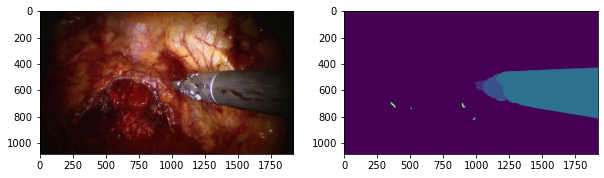

In [8]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

In [9]:
np.unique(mask)

array([0, 1, 2, 3, 8], dtype=int64)

In [1]:
3

3